In [2]:
# Pyhthon 3.7 모델 설치
import sys

assert sys.version_info >= (3, 7)

In [3]:
!pip install tensorflow

from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 MB 35.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 62.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 65.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 58.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.1
    Uninstalling numpy-2.1.1:
      Successfully uninstalled numpy-2.1.1

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


2024-12-11 23:22:19.435083: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-11 23:22:19.461491: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-11 23:22:19.492678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733959339.526111    4981 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733959339.535394    4981 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 23:22:19.566579: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [4]:
import sys
# google colab의 경우 나눔 폰트를 설치
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용
import matplotlib

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

In [5]:
# 모델 튜닝을 위해 keras-tuner를 설치
!pip install keras-tuner


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [6]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import files
    # Colab에서 필요한 추가 코드 (예: 파일 업로드)
    uploaded = files.upload()
else:
    print("This code is not running in Google Colab.")


This code is not running in Google Colab.


In [7]:
import pandas as pd

df = pd.read_csv("datasets/BostonHousing.csv")
X = df.iloc[:, :-1].values  # 입력 특성
y = df.iloc[:, -1].values  # 출력 값

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 데이터 로드
df = pd.read_csv("datasets/BostonHousing.csv")
X = df.iloc[:, :-1].values  # 입력 특성
y = df.iloc[:, -1].values  # 출력 값

# 데이터 분리
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = np.nan_to_num(scaler.fit_transform(X_train))
X_valid_scaled = np.nan_to_num(scaler.transform(X_valid))
X_test_scaled = np.nan_to_num(scaler.transform(X_test))
y_train = np.nan_to_num(y_train)
y_valid = np.nan_to_num(y_valid)
y_test = np.nan_to_num(y_test)

# 사용자 정의 HuberLoss 함수
class HuberLoss(tf.keras.losses.Loss):
    def __init__(self, threshold=1.0, **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

# 모델 구조 정의
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256, step=16)
    learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-3, sampling="log")
    optimizer = hp.Choice("optimizer", values=["adam", "sgd"])

    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(X_train_scaled.shape[1],)))
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu", kernel_initializer="he_normal"))
    model.add(tf.keras.layers.Dense(1))

    loss = HuberLoss(threshold=hp.Float("threshold", min_value=0.5, max_value=5.0, step=0.5))
    model.compile(loss=loss, optimizer=optimizer, metrics=["mae"])
    return model

# 이 문단부터 하이퍼 파라미터
# Keras Tuner 설정
tuner = kt.Hyperband(
    build_model,
    objective="val_mae",
    max_epochs=20,
    factor=3,
    directory="tuner_dir",
    project_name="huber_loss_tuning",
    max_consecutive_failed_trials=10
)

# 하이퍼파라미터 검색 실행
tuner.search(
    X_train_scaled, y_train,
    validation_data=(X_valid_scaled, y_valid),
    verbose=2
)

# 최적의 하이퍼파라미터로 모델 재설정 및 훈련
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = build_model(best_hps)
history = model.fit(X_train_scaled, y_train, validation_data=(X_valid_scaled, y_valid), epochs=20)

# 모델 평가
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)

# 모델 저장
model.save("final_model.keras")

# 최종 평가 결과 출력
print(f"Test loss: {test_loss}")
print(f"Test MAE: {test_mae}")


Reloading Tuner from tuner_dir/huber_loss_tuning/tuner0.json
Epoch 1/20


2024-12-11 23:22:25.342022: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 17.4672 - mae: 17.9560 - val_loss: 8.6795 - val_mae: 8.7572
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4629 - mae: 8.9411 - val_loss: 8.1046 - val_mae: 8.7270
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.3834 - mae: 8.8608 - val_loss: 6.7102 - val_mae: 7.3657
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.2971 - mae: 7.7597 - val_loss: 6.9079 - val_mae: 8.0044
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.9994 - mae: 7.5615 - val_loss: 6.3785 - val_mae: 6.9433
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8240 - mae: 7.2730 - val_loss: 6.5894 - val_mae: 7.5165
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0834 - mae: 7.8543 - val_loss: 6.3446 - val_mae: 7.1143
Epoch 8/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8054 - mae: 7.3452 - val_loss: 6.2014 - val_mae: 6.6903
Epoch 9/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.7833 - mae: 7.2512 -

In [9]:
results = {"Metric": ["Test Loss", "Test MAE"], "Value": [test_loss, test_mae]}
df = pd.DataFrame(results)
df.to_csv("results.csv", index=False)

# CSV 다운로드
files.download("datasets/BostonHousing.csv")

NameError: name 'files' is not defined

In [10]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_network(input_shape=(0,)):
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=input_shape))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [11]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 150
all_scores = []
all_history = []
for i in range(k):
    print('폴드 번호 #{}'.format(i))
    fold_start_index = i * num_val_samples
    fold_end_index = (i + 1) * num_val_samples

    val_data = train_data[fold_start_index : fold_end_index]
    val_targets = train_targets[fold_start_index : fold_end_index]

    partial_train_data = np.concatenate(
        [train_data[:fold_start_index], train_data[fold_end_index:]],
        axis=0
    )

    partial_train_targets = np.concatenate(
        [train_targets[:fold_start_index], train_targets[fold_end_index:]],
        axis=0
    )

    model = build_network((partial_train_data.shape[1], ))
    history = model.fit(
        partial_train_data,
        partial_train_targets,
        epochs=num_epochs,
        validation_data=(val_data, val_targets),
        batch_size=1,
        verbose=0
    )
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mse)
    all_history.append(history.history)

NameError: name 'train_data' is not defined

In [12]:
val_mae_lst = [hist['val_mae'] for hist in all_history]
val_mae_lst = np.array(list(val_mae_lst))
avg_mae = [
    np.mean([x[i] for x in val_mae_lst]) for i in range(num_epochs)
]

NameError: name 'all_history' is not defined

In [13]:
val_mae_lst = [hist['val_loss'] for hist in all_history]
val_mae_lst = np.array(list(val_mae_lst))
avg_mae = [
    np.mean([x[i] for x in val_mae_lst]) for i in range(num_epochs)
]

NameError: name 'all_history' is not defined

In [14]:
import matplotlib.pyplot as plt
def smooth_curve(points, factor=.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [15]:
def show_graph(data):
    smooth_data = smooth_curve(data)
    plt.plot(range(1, len(smooth_data) + 1), smooth_data)
    plt.xlabel('Epochs')
    plt.ylabel('Validation MAE')
    plt.show()

In [16]:
show_graph(avg_mae[10:])

NameError: name 'avg_mae' is not defined

키 설정


In [17]:
# all_history 내 각 요소의 키를 확인
for i, hist in enumerate(all_history):
    print(f"Fold {i} history keys:", hist.keys())


NameError: name 'all_history' is not defined

In [18]:
for i, hist in enumerate(all_history):
    print(f"Fold {i} keys: {list(hist.keys())}")


NameError: name 'all_history' is not defined

In [19]:
val_mae_lst = [
    hist['val_mae'] for hist in all_history if 'val_mae' in hist
]


NameError: name 'all_history' is not defined

In [20]:
for i, hist in enumerate(all_history):
    print(f"Fold {i} history:", hist)


NameError: name 'all_history' is not defined

In [21]:
# 각 폴드의 history에서 키 확인
for i, hist in enumerate(all_history):
    print(f"Fold {i} history keys: {list(hist.keys())}")


NameError: name 'all_history' is not defined

In [22]:
# val_mae_lst 추출
val_mae_lst = [
    hist['val_mae'] for hist in all_history if 'val_mae' in hist
]

# numpy 배열로 변환
val_mae_lst = np.array(val_mae_lst)

# 에포크별 평균 MAE 계산
avg_mae = [
    np.mean(val_mae_lst[:, i]) for i in range(val_mae_lst.shape[1])
]

print("에포크별 평균 MAE:", avg_mae)


NameError: name 'all_history' is not defined

In [23]:
for i, hist in enumerate(all_history):
    print(f"Fold {i} history data:", hist)


NameError: name 'all_history' is not defined

In [24]:
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mean_absolute_error']  # 또는 ['mae']
)


In [25]:
# 모든 폴드의 history 데이터 확인
for i, hist in enumerate(all_history):
    print(f"Fold {i} history:")
    for key, value in hist.items():
        print(f"  {key}: {value[:5]}...")  # 처음 5개의 값만 출력


NameError: name 'all_history' is not defined

In [26]:
val_mae_lst = [
    hist['val_mae'] for hist in all_history if 'val_mae' in hist
]


NameError: name 'all_history' is not defined

In [27]:
val_mae_lst = []
for hist in all_history:
    if 'val_mean_absolute_error' in hist:
        val_mae_lst.append(hist['val_mean_absolute_error'])
    elif 'val_mae' in hist:  # 다른 대체 키 확인
        val_mae_lst.append(hist['val_mae'])
    else:
        print("경고: 이 history에 'val_mean_absolute_error' 또는 'val_mae'가 없습니다.", hist.keys())


NameError: name 'all_history' is not defined

In [28]:
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mean_absolute_error']  # 또는 'mae'
)


In [29]:
# 모든 history 데이터에서 문제가 있는 항목 확인
for i, hist in enumerate(all_history):
    if not isinstance(hist, dict):
        print(f"Fold {i} 데이터가 잘못되었습니다: {hist}")
    elif 'val_mean_absolute_error' not in hist:
        print(f"Fold {i}에서 'val_mean_absolute_error' 키가 없습니다. 키들: {list(hist.keys())}")


NameError: name 'all_history' is not defined

In [30]:
# val_mae_lst를 numpy 배열로 변환
val_mae_lst = np.array(val_mae_lst)

# 에포크별 평균 MAE 계산
avg_mae = [
    np.mean(val_mae_lst[:, i]) for i in range(val_mae_lst.shape[1])
]

print("에포크별 평균 MAE:", avg_mae)


IndexError: tuple index out of range

In [39]:
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [40]:
df = pd.read_csv("datasets/BostonHousing.csv")




In [41]:
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [42]:
# 그래프 배경 설정
sns.set_style('darkgrid')

In [43]:
# shape (dimension)
df.shape

(506, 14)

In [44]:
# 결측치
df.isnull().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
b          0
lstat      0
medv       0
dtype: int64

In [45]:
# data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [46]:
# numerical variable
df.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [47]:
# categorical variable
num_town = df['TOWN'].unique()
print(len(num_town))
num_town


KeyError: 'TOWN'

In [ ]:
# 기초 통계량
df['CMEDV'].describe()

KeyError: 'MEDV'

In [50]:
# 분포
df['CMEDV'].hist(bins=50)

KeyError: 'CMEDV'

KeyError: "None of [Index(['CMEDV'], dtype='object')] are in the [columns]"

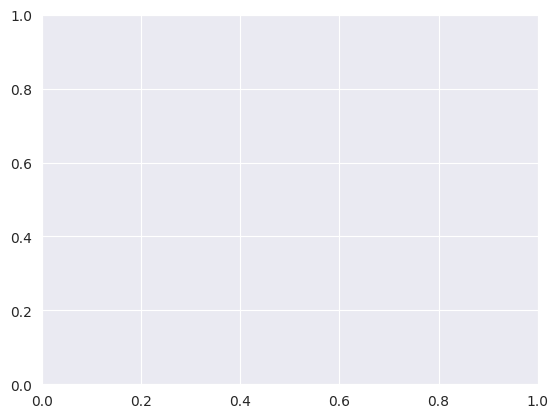

In [51]:
# boxplot - Pandas
df.boxplot(column=['CMEDV'])
plt.show()

In [52]:
# boxplot - matplotlib
plt.boxplot(df['CMEDV'])
plt.show()


KeyError: 'CMEDV'

KeyError: "None of [Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',\n       'PTRATIO', 'B', 'LSTAT'],\n      dtype='object')] are in the [columns]"

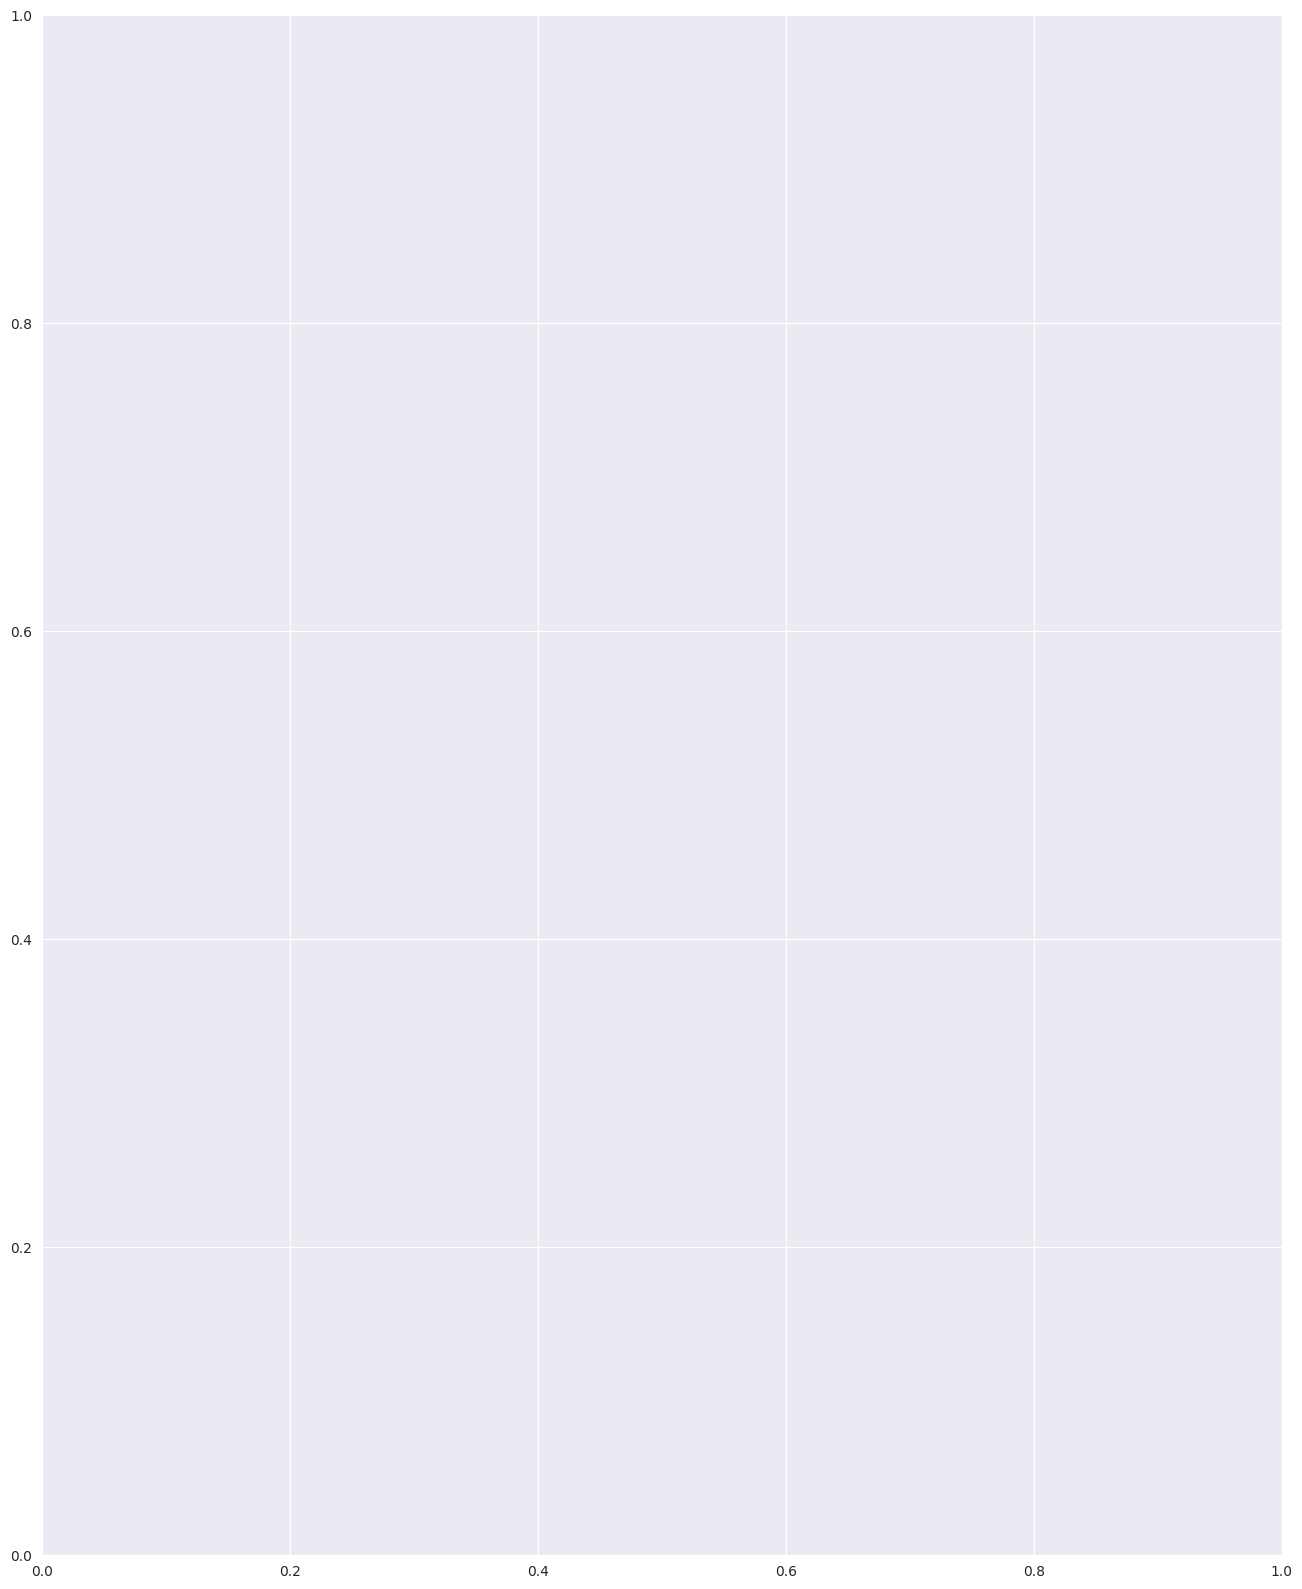

In [53]:
# numerical features (except "LON" & "LAT")
numerical_columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

fig = plt.figure(figsize = (16, 20))
ax = fig.gca()  # Axes 생성

df[numerical_columns].hist(ax=ax)
plt.show()

In [ ]:
# Person 상관계수
cols = ['CMEDV', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

corr = df[cols].corr(method = 'pearson')
corr


NameError: name 'corr' is not defined

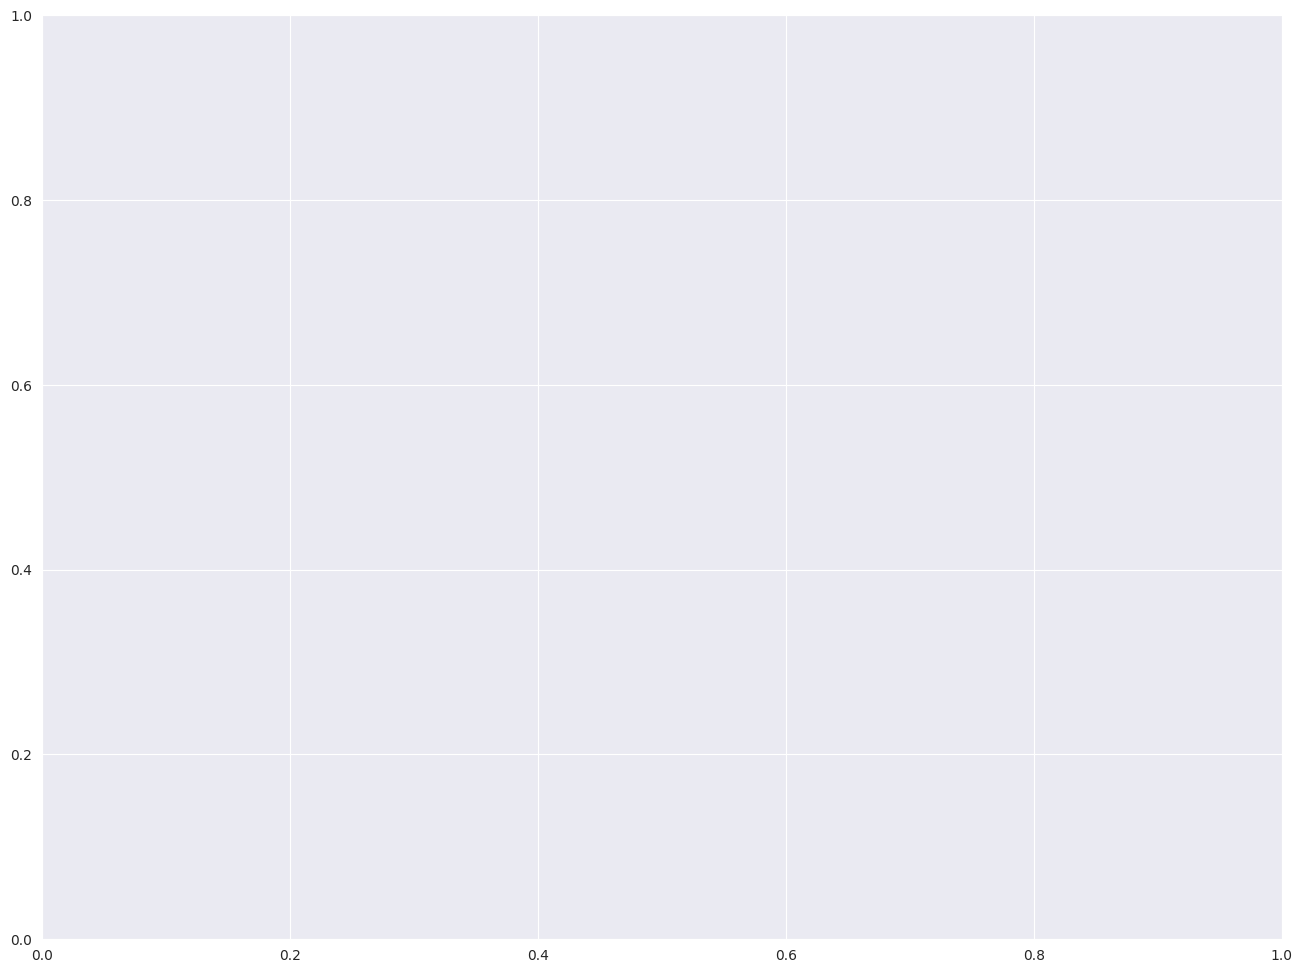

In [54]:
# heatmap (seaborn)
fig = plt.figure(figsize = (16, 12))
ax = fig.gca()

sns.set(font_scale = 1.5)  # heatmap 안의 font-size 설정
heatmap = sns.heatmap(corr.values, annot = True, fmt='.2f', annot_kws={'size':15},
                      yticklabels = cols, xticklabels = cols, ax=ax, cmap = "RdYlBu")
plt.tight_layout()
plt.show()

In [55]:
# scatter plot
sns.scatterplot(data=df, x='RM', y='CMEDV', markers='o', color='blue', alpha=0.6)
plt.title('Scatter Plot')
plt.show()

ValueError: Could not interpret value `RM` for `x`. An entry with this name does not appear in `data`.

In [56]:
# scatter plot
sns.scatterplot(data=df, x='LSTAT', y='CMEDV', markers='o', color='blue', alpha=0.6)
plt.title('Scatter Plot')
plt.show()

ValueError: Could not interpret value `LSTAT` for `x`. An entry with this name does not appear in `data`.

In [57]:
# 도시별 데이터 갯수
df['TOWN'].value_counts()

KeyError: 'TOWN'

In [58]:
# 도시별 데이터 갯수 (bar plot)
df['TOWN'].value_counts().hist(bins=50)

KeyError: 'TOWN'

In [59]:
# 도시별 주택 가격 특징 (boxplot 이용)
fig = plt.figure(figsize = (12, 20))
sns.boxplot(x='CMEDV', y='TOWN', data=df)

ValueError: Could not interpret value `CMEDV` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x2000 with 0 Axes>

In [60]:
# 도시별 범죄율 특징
fig = plt.figure(figsize = (12, 20))
sns.boxplot(x='CRIM', y='TOWN', data=df)

ValueError: Could not interpret value `CRIM` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x2000 with 0 Axes>

In [61]:
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [ ]:

# feature standardization  (numerical_columns except dummy var.-"CHAS")
scaler = StandardScaler()  # 평균 0, 표준편차 1
scale_columns = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
df[scale_columns] = scaler.fit_transform(df[scale_columns])

In [ ]:
df.head()

In [ ]:
# features for linear regression model
df[numerical_columns].head()

In [ ]:

# split dataset into training & test
X = df[numerical_columns]
y = df['CMEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
X_train.shape, y_train.shape

In [ ]:
X_test.shape, y_test.shape

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['features'] = X_train.columns
vif["VIF Factor"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif.round(1)

In [ ]:
from sklearn import linear_model

# fit regression model in training set
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)

# predict in test set
pred_test = lr.predict(X_test)

In [ ]:
# print coef
print(lr.coef_)

In [63]:
# "feature - coefficients" DataFrame 만들기
coefs = pd.DataFrame(zip(df[numerical_columns].columns, lr.coef_), columns = ['feature', 'coefficients'])
coefs

KeyError: "None of [Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',\n       'PTRATIO', 'B', 'LSTAT'],\n      dtype='object')] are in the [columns]"

In [64]:
# 크기 순서로 나열
coefs_new = coefs.reindex(coefs.coefficients.abs().sort_values(ascending=False).index)
coefs_new

NameError: name 'coefs' is not defined

In [65]:
## coefficients 시각화

# figure size
plt.figure(figsize = (8, 8))

# bar plot
plt.barh(coefs_new['feature'], coefs_new['coefficients'])
plt.title('"feature - coefficient" Graph')
plt.xlabel('coefficients')
plt.ylabel('features')
plt.show()

NameError: name 'coefs_new' is not defined

<Figure size 800x800 with 0 Axes>

In [66]:
import statsmodels.api as sm

X_train2 = sm.add_constant(X_train)
model2 = sm.OLS(y_train, X_train2).fit()
model2.summary()

ModuleNotFoundError: No module named 'statsmodels'

In [67]:
# 예측 결과 시각화 (test set)
df = pd.DataFrame({'actual': y_test, 'prediction': pred_test})
df = df.sort_values(by='actual').reset_index(drop=True)

plt.figure(figsize=(12, 9))
plt.scatter(df.index, df['prediction'], marker='x', color='r')
plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
plt.title("Prediction Result in Test Set", fontsize=20)
plt.legend(['prediction', 'actual'], fontsize=12)
plt.show()

NameError: name 'pred_test' is not defined

In [68]:
# R square
print(model.score(X_train, y_train))  # training set
print(model.score(X_test, y_test))  # test set

AttributeError: 'Sequential' object has no attribute 'score'

In [69]:
# RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

# training set
pred_train = lr.predict(X_train)
print(sqrt(mean_squared_error(y_train, pred_train)))

# test set
print(sqrt(mean_squared_error(y_test, pred_test)))

NameError: name 'lr' is not defined